In [1]:
#!python --version

In [2]:
#!pip install networkx
#!pip install peartree
#!pip install osmnx
#!pip install numpy 
#!pip install random
#!pip install folium==0.11.0
#!pip install imgkit==1.0.2
#!pip install selenium==3.141.0

#pip install networkx peartree osmnx numpy folium==0.11.0 imgkit==1.0.2 selenium

In [3]:
from collections import defaultdict, OrderedDict, Counter
import networkx as nx
import numpy as np
import peartree as pt
import random

############### MY MODULES ###############
import sim
from sensor import *
from scenerio import *
from dsp_memo import DspMemo

In [4]:
############ GLOBAL VARIABLES #############

def reset_network():
    global_variables = {
        'time_table': None,
        'feed': None,
        'G': None,
        'stop_times': None,
        'routes': None,
        'trips': None,
        'all_routes': None,
        'all_trips': None,

        'stop_times_dict': None,
        'trips_per_stop': None,
        'routes_per_stop': None,
        'stop_ranks': None,
        'route_subgraphs': None,
        'edge_departures': None,
        'trip_subgraphs': None,
        'stops_per_trip': None,
        'dsp_memo':None
    }
    
    globals().update(global_variables)
    
def reset_sim():
    global_variables = {
        'error': 0,
        'routes_per_gateway': None,
        'gateways_per_route': None,
        'all_gateways': None,
        'all_sensors': None,
        'sensor_count': None,
        'sensor_objects': None,
    }

    globals().update(global_variables)

In [5]:
################## HELPER FUNCTIONS ##################

def get_stopid(node_name):
    return node_name.split('_')[-1]


def namify_stop(g_name,stop_id):
    return "{0}_{1}".format(g_name,stop_id)


def invert_dict(d):
    inverted_d = defaultdict(set)
    for k in d.keys():
        for v in d[k]:
            inverted_d[v].add(k)
    return inverted_d

# I don't think this is useful
def get_routes_per_stop_id(stop_id):
    for stop_id in time_table.stop_id.unique():
            routes = time_table[time_table.stop_id == stop_id].route_id.unique()
            return set(routes)


def get_time_to_next_departure(current_time, departure_list):
    try:
        next_departure = min(v for v in departure_list if v >= current_time)
        wait_time = next_departure - current_time
    except:
        wait_time = None

    return wait_time

In [6]:
def load_network():
    global feed,G,dsp_memo

    feed = pt.get_representative_feed('data/gtfs/' + sim.network_file)
    G = pt.load_feed_as_graph(feed, sim.start, sim.end, interpolate_times=True)
    dsp_memo = DspMemo()
    
def load_stop_times():
    global stop_times, routes, trips, time_table


    stop_times = feed.stop_times
    routes = feed.routes
    trips = feed.trips

    stoptimes_trips = stop_times.merge(trips, left_on='trip_id', right_on='trip_id')
    stoptimes_trips_routes = stoptimes_trips.merge(routes, left_on='route_id', right_on='route_id')

    columns = ['route_id',
               'service_id',
               'trip_id',
               #'trip_headsign',
               'direction_id',
               #'block_id',
               #'shape_id',
               #'route_short_name',
               #'route_long_name',
               'route_type',
               'arrival_time',
               'departure_time',
               'stop_id',
               'stop_sequence'
              ]

    time_table = stoptimes_trips_routes[columns]

def format_stop_times():
    global time_table, all_trips, all_routes

    #time_table = pt.summarizer._trim_stop_times_by_timeframe(time_table, sim.start, sim.end)

    time_table = time_table[~time_table['route_id'].isnull()]

    time_table = pt.summarizer._linearly_interpolate_infill_times(
        time_table,
        use_multiprocessing=False)

    if 'direction_id' in time_table:
        # If there is such column then check if it contains NaN
        has_nan = time_table['direction_id'].isnull()
        if sum(has_nan) > 0:
            # If it has no full coverage in direction_id, drop the column
            time_table.drop('direction_id', axis=1, inplace=True)

    # all_routes = set(feed.routes.route_id.values)
    all_routes = set(time_table.route_id.unique())
    all_trips = set(time_table.trip_id.unique())



def analyze_stops():
    global stop_times_dict, trips_per_stop, routes_per_stop, stop_ranks
    stop_times_dict = defaultdict(dict)
    trips_per_stop = defaultdict(set)
    routes_per_stop = defaultdict(set)
    routes_per_stop = defaultdict(set)
    stop_ranks = OrderedDict()

    for i,row in time_table.iterrows():
       trips_per_stop[row.stop_id].add(row.trip_id)
       routes_per_stop[row.stop_id].add(row.route_id)

    d = {}
    for k,v in routes_per_stop.items():
        d[k] = len(v)

    for k in sorted(d, key=d.get, reverse=True):
        stop_ranks[k] = d[k]
    #stop_ranks = {k:d[k] for k in sorted(d, key=d.get, reverse=True)} 
    
def assign_gateways_to_nodes():
    global all_gateways #input
    global G #output

    attr = {gw:True for gw in all_gateways}
    nx.set_node_attributes(G, name='is_gateway', values=attr)

    return G



In [7]:
#### Add departure times of source node to edges
def get_departure_times_per_edge_per_route():
    import pandas as pd

    global time_table  # input
    global edge_departures  # output

    has_dir_col = 'direction_id' in time_table.columns.values

    all_deps = []
    all_route_ids = []
    all_trip_ids = []
    all_from_stop_ids = []
    all_to_stop_ids = []

    for trip_id in time_table.trip_id.unique():

        tst_sub = time_table[time_table.trip_id == trip_id]
        route = tst_sub.route_id.values[0]

        # Just in case both directions are under the same trip id
        for direction in [0, 1]:
            # Support situations where direction_id is absent from the
            # GTFS data. In such situations, include all trip and stop
            # time data, instead of trying to split on that column
            # (since it would not exist).
            if has_dir_col:
                dir_mask = (tst_sub.direction_id == direction)
                tst_sub_dir = tst_sub[dir_mask]
            else:
                tst_sub_dir = tst_sub.copy()

            tst_sub_dir = tst_sub_dir.sort_values('stop_sequence')
            
            deps = tst_sub_dir.departure_time[:-1]

            # Add each resulting list to the running array totals
            all_deps += list(deps)

            from_ids = tst_sub_dir.stop_id[:-1].values
            all_from_stop_ids += list(from_ids)

            to_ids = tst_sub_dir.stop_id[1:].values
            all_to_stop_ids += list(to_ids)

            all_route_ids.extend([route] * len(deps))
            all_trip_ids.extend([trip_id] * len(deps))

    # Only return a dataframe if there is contents to populate
    # it with
    if len(all_deps) > 0:
        # Now place results in data frame
        edge_departures = pd.DataFrame({
            'from_stop_id': all_from_stop_ids,
            'to_stop_id': all_to_stop_ids,
            'departure_times': all_deps,
            'route_id': all_route_ids,
            'trip_id': all_trip_ids})

        
def add_departure_to_edge():
    global edge_departures  # input
    global G  # output

    for i, row in edge_departures.drop_duplicates(['from_stop_id', 'to_stop_id']).iterrows():
        u,v = row.from_stop_id, row.to_stop_id

        dep_mask = (edge_departures['from_stop_id'] == u) & (edge_departures['to_stop_id'] == v)
        #dep_list = edge_deps[dep_mask].deps.values
        dep_list = edge_departures[dep_mask][['route_id', 'departure_times']].sort_values(['departure_times'])

        dep_per_route = dep_list.groupby('route_id')['departure_times'].apply(lambda x: x.tolist()).to_dict(into=OrderedDict)

        u,v =  namify_stop(G.name,u), namify_stop(G.name,v)

        #TODO:: find out why you have to do this
        if u in G and v in G[u]:
            G[u][v][0]['departure_time'] = dep_per_route


    #test to make sure all edges is serviced
    for x in G.edges(keys=True,data=True):
        if 'departure_time' not in x[3]:
            print(x)

In [8]:
#g = add_departure_to_edge()
#g

In [9]:
## Randomly selects stops to serve as sensors
def randomly_select_sensor_locations():
    global G # input
    global all_sensors, sensor_count # output


    all_stops = set(G.nodes)
    sensor_count = round(len(all_stops) * sim.pct_stops_as_sensors / 100)

    eligible_stops = list(all_stops - set(all_gateways)) #remove gateways from the list
    all_sensors = np.random.choice(eligible_stops, size=sensor_count, replace=False)


## Mark selected nodes as sensors
def assign_sensors_to_nodes():
    global all_sensors  # input
    global G  # output

    attr = {sensor:True for sensor in all_sensors}

    nx.set_node_attributes(G, name='is_sensor', values=attr)


def generate_sensors():
    global all_sensors, routes_per_stop # input
    global sensor_objects # output

    sensor_objects = {}

    msg_gen_rate = np.random.randint(low = sim.msg_gen_rate_range[0], high= sim.msg_gen_rate_range[1], size=len(all_sensors)) # 10mins to 12 hours
    start_time = np.random.randint(low = sim.msg_gen_rate_range[0], high=sim.msg_gen_rate_range[1], size=len(all_sensors)) # 0 to 1 hour
    np.random.shuffle(start_time)

    print(sum(msg_gen_rate), sum(start_time))

    #exit()


    for i,sensor_name in enumerate(all_sensors):
        #print(i,sensor_name)
        #r = get_routes_per_stop_id(get_stopid(sensor_name))
        r = routes_per_stop[get_stopid(sensor_name)]

        s = OnRouteSensor(name=sensor_name, routes=r, start_time=start_time[i], msg_gen_rate=msg_gen_rate[i], msg_ttl=None, data_size=None)
        sensor_objects[sensor_name]=s


def generate_route_subgraphs():
    global G, routes_per_stop, all_routes # input
    global route_subgraphs, stops_per_route # output

    route_subgraphs = {}
    stops_per_route = invert_dict(routes_per_stop)

    for r in all_routes:
        sub_nodes = [namify_stop(G.name, s) for s in stops_per_route[r]]
        # G.remove_nodes_from([n for n in G if n not in set(nodes)])
        sub_graph = G.subgraph(sub_nodes).copy()
        route_subgraphs[r] = sub_graph



def calculate_delay(routes, sensor, time):
    """
    find shortest path from sensor node to a gateway node in the graph, weight is edge cost,
    while factoring in duration from current time to next next dept time for that edge.

    save gen_time and latency to sensor object

    remember departure time, distance is in seconds
    while "time", gen_time,start_time is in minutes.
    so remember to convert it.
    """
    global G, route_subgraphs, gateways_per_route, dsp_memo  # inputs

    global error

    import sys
    waiting_time = None
    shortest_distance, shortest_path = sys.float_info.max, None  # to any gateway


    for r in routes:
        for gateway in gateways_per_route[r]:

            g = route_subgraphs[r].copy()

            wait_time = None

            try:
                distance, path = dsp_memo.getDsp(g, r, sensor.name, namify_stop(G.name, gateway))
#                 distance, path = nx.single_source_dijkstra(g, sensor.name, namify_stop(G.name, gateway), weight='length')
            except Exception as e:
                continue

            while len(path) > 1:
                '''
                make sure then you limit duration to 24 hours. later if time is greater than 24
                message is not delivered
                '''

                # TODO:: error rate too high.. fix it.
                #print(path)
                departure_list = g[sensor.name][path[1]][0]['departure_time'].get(r, None)

                #print(departure_list)
                if departure_list == None:
                    # print("no departure time found")
                    break
                    #g.remove_node(path[1])
                    #continue

                else:
                    wait_time = get_time_to_next_departure(current_time=time, departure_list=departure_list)
                    break


            if wait_time != None:

                if distance + wait_time < shortest_distance:
                    shortest_distance, shortest_path = distance + wait_time, path
                    waiting_time = wait_time
                    #break

    if waiting_time == None:
        shortest_distance = None
        error +=1


    sensor.gen_times.append(time)  # in sec
    sensor.msg_latencies.append(shortest_distance)  # in sec
    sensor.waiting_time.append(waiting_time)
    sensor.hops.append(shortest_path)



def store_results():
    import json
    from collections import defaultdict
    final_result = defaultdict(list)

    final_result['sim_time'] = sim.duration

    # print(sensor_objects.values())
    # type(sensor_objects.values()[0])

    for s in sensor_objects.values():

        data = {
            'delivery_rate': None,
            'no_of_routes': len(s.routes),
            'all_latencies': s.msg_latencies,
            'all_waiting_times': s.waiting_time ,
            'all_gen_times': s.gen_times,
            'all_hops': s.hops,
            'delivered_latencies': [],
            'delivered_gen_times': [],
            'delivered_waiting_times':[],
            'delivered_hops':[],
        }

        for i in range(len(s.msg_latencies)):
            if (s.msg_latencies[i] != None) and (s.gen_times[i] + s.msg_latencies[i] < sim.duration * 60):
                data['delivered_latencies'].append(s.msg_latencies[i])
                data['delivered_gen_times'].append(s.gen_times[i])

                data['delivered_waiting_times'].append(s.waiting_time[i])
                data['delivered_hops'].append(s.hops[i])

        # print(len(s.gen_times))

        if (len(s.gen_times) != 0):
            data['delivery_rate'] = len(data['delivered_latencies']) / len(s.gen_times)

        final_result['ons'].append(data)

    with open('results/{0}_data_{1}.txt'.format(sim.network_file, sim.seed), 'w') as outfile:
        json.dump(final_result, outfile, indent=True)

    print("Results Stored!")


def run_simulation():
    global sensor_objects, routes_per_stop
    global error

    for time in range(int(sim.start/60), sim.duration + 1):
        for name, sensor in sensor_objects.items():
            if sensor.generate_msg(time):
                routes = routes_per_stop[get_stopid(sensor.name)]
                # change time to secs
                calculate_delay(routes, sensor, time * 60)

    print("Simulation Completed! for seed_{0}".format(sim.seed))
    print(error)


In [10]:
def print_stats():
    global all_routes, all_gateways, stop_ranks
    print("{} Routes, {} Gateways, {} stops".format(len(all_routes), len(all_gateways), len(stop_ranks)))

# GTFS FUNCTIONS

In [11]:
for network in sim.network_file_list:
    reset_network()
    sim.network_file = network
    
    load_network()
    load_stop_times()
    format_stop_times()
    analyze_stops()
    get_departure_times_per_edge_per_route()
    add_departure_to_edge()
    
    generate_route_subgraphs()
    #generate_trip_subgraphs()
    
    #for seed in range(0, sim.no_of_seeds):
    for seed in [0]:
        reset_sim()

        sim.seed = 0
        
        np.random.seed(sim.seed)
        random.seed(sim.seed)
        #print_stats()
        print("Loaded!")
        #randomly_select_sensor_locations()
        #assign_sensors_to_nodes()
        #generate_sensors()
        #generate_route_subgraphs()
        #run_simulation()
        #store_results()

        #reset_sim()

Loaded!
Loaded!


In [12]:
im_g = ['778638', '778671', '778806', '778650', '778860']
routes_covered = {route for stop in im_g[:4] for route in routes_per_stop[stop]}
len(routes_covered)

26

In [13]:
pt.plot??

/Users/briareed/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/Users/briareed/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/briareed/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyp

(<Figure size 576x864 with 1 Axes>, <AxesSubplot:>)

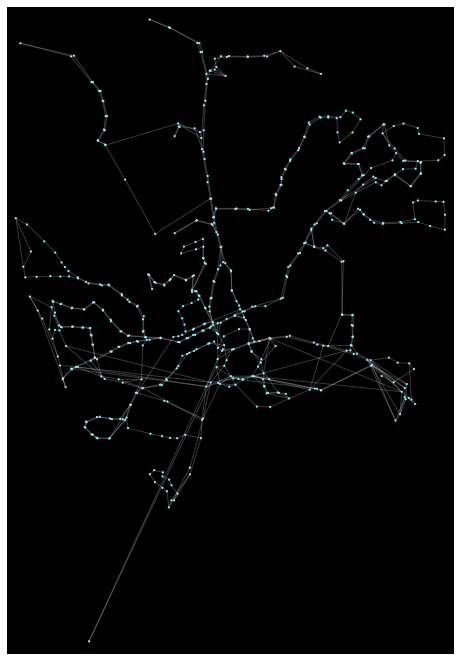

In [14]:
import osmnx as ox
ox.plot_graph(G,
                            figsize=(8,12),
                            show=False,
                            close=False,
                            node_color='#8aedfc',
                            node_size=5,
                            edge_color='#e2dede',
                            edge_alpha=0.25,
                            bgcolor='black')

In [15]:
#import osmnx as ox
import numpy as np
import folium as fm

def add_stops(m):
    
    t = fm.FeatureGroup(name='stops')
    
    for s in G.nodes:
        loc = (G.nodes[s]['y'], G.nodes[s]['x'])
        
        fm.CircleMarker(loc, 
                         color='red',
                         opacity=1,
                         weight= 1,
                         fill_color='red',
                         fill_opacity=0.9,
                         radius=2, 
                       ).add_to(t)
        
    m.add_children(t)

m = ox.plot_graph_folium(G, graph_map=None, popup_attribute=None, tiles='cartodbpositron', zoom=10, fit_bounds=True, edge_color='#e2dede', edge_width=1, edge_opacity=0.25)
add_stops(m)
#map.add_children(fm.LayerControl())
m.save('map.html')
m
#m

/Users/briareed/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-15-f1343ce88031>:21: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  m.add_children(t)


In [16]:
import imgkit
options = {
    'format': 'png',
    'crop-h': '3',
    'crop-w': '3',
    'crop-x': '3',
    'crop-y': '3',
    'encoding': "UTF-8",
    'custom-header' : [
        ('Accept-Encoding', 'gzip')
    ],
    'cookie': [
        ('cookie-name1', 'cookie-value1'),
        ('cookie-name2', 'cookie-value2'),
    ]
}

imgkit.from_file('chapel-hill.html', 'out.png', options=options)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [17]:
#!pip install selenium==3.150.0

In [18]:
import selenium.webdriver as webdriver
chromeOptions = webdriver.ChromeOptions() 
chromeOptions.add_experimental_option("prefs", {"profile.managed_default_content_settings.images": 2}) 
chromeOptions.add_argument("--no-sandbox") 
chromeOptions.add_argument("--disable-setuid-sandbox") 

chromeOptions.add_argument("--remote-debugging-port=9222")  # this

chromeOptions.add_argument("--disable-dev-shm-using") 
chromeOptions.add_argument("--disable-extensions") 
chromeOptions.add_argument("--disable-gpu") 
chromeOptions.add_argument("start-maximized") 
chromeOptions.add_argument("disable-infobars")
chromeOptions.add_argument(r"user-data-dir=.\cookies\\test")
driver = webdriver.Chrome()
driver.set_window_size(2000, 1500)  # choose a resolution
driver.get('/Users/briareed/Desktop/Amli/low_cost_smart_city_optimization/chapel-hill.html') #This needs to be the complete path on the slected computer
# You may need to add time.sleep(seconds) here
time.sleep(20)
driver.save_screenshot('screen.png')

InvalidArgumentException: Message: invalid argument
  (Session info: chrome=103.0.5060.134)


In [20]:
in_degree_centrality = nx.in_degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G, u=None, distance='length', wf_improved=True)
#betweenness_centrality = nx.betweenness_centrality(G)

closeness_centrality =  sorted(closeness_centrality.items(), key= lambda x: x[1], reverse=False)
in_degree_centrality = sorted(in_degree_centrality.items(), key= lambda x: x[1], reverse=True)
#betweenness_centrality = sorted(betweenness_centrality.items(), key= lambda x: x[1], reverse=True)
#t = nx.edge_betweenness_centrality(G)
#t = nx.pagerank(G)
closeness_centrality

[('8BNPN_778916', 0.0003098597436129417),
 ('8BNPN_778914', 0.0003102556788012011),
 ('8BNPN_778911', 0.0003148991143335283),
 ('8BNPN_778910', 0.00031497641180420024),
 ('8BNPN_778908', 0.0003197633179728434),
 ('8BNPN_778906', 0.0003246979691183539),
 ('8BNPN_778904', 0.0003251327590773861),
 ('8BNPN_778902', 0.000325568715017144),
 ('8BNPN_778967', 0.0003303208597796976),
 ('8BNPN_778978', 0.00033522692766957234),
 ('8BNPN_778899', 0.00033596590818835685),
 ('8BNPN_778898', 0.00034141757525312),
 ('8BNPN_779006', 0.00034178905899498295),
 ('8BNPN_778897', 0.00034228910626311003),
 ('8BNPN_778917', 0.00034794964434021103),
 ('8BNPN_779008', 0.0003486132297478644),
 ('8BNPN_778918', 0.0003538702279355117),
 ('8BNPN_778920', 0.0003543158217859026),
 ('8BNPN_778919', 0.00035956355604976437),
 ('8BNPN_778835', 0.00036272551242645906),
 ('8BNPN_779009', 0.00036348694102645944),
 ('8BNPN_778495', 0.00036466647464913866),
 ('8BNPN_779014', 0.00037082493559379814),
 ('8BNPN_779012', 0.000371

In [21]:
def generate_sensor_scenerios(set_count, min_sensors, max_sensors):
    import random
    global G, routes_per_stop, all_routes, dsp_memo  # input
    #global sensor_scenerios #output
    
    #TODO:: seed works only if called from within where it is set
    #sim.seed = 0
    np.random.seed(sim.seed)
    random.seed(sim.seed)

    sensor_scenerios = []
    all_stops = [s for s in set(G.nodes)]

    for _ in range(set_count):
        sensor_count = random.randint(min_sensors, max_sensors)
        scenerio = Scenerio(graph=G,
                            dsp_memo = dsp_memo,
                            all_stops= all_stops,
                            all_routes= all_routes,
                            routes_per_stop=routes_per_stop,
                            sensor_count=sensor_count
                            )
        
        sensor_scenerios.append(scenerio)
        
    return sensor_scenerios
        
#generate_sensor_scenerios(2, 20, 50)

In [22]:
def compute_delay(graph, gateways, scenerios):
    total_delay = 0

    for scenerio in scenerios:
        total_delay += scenerio.calculate_penalty_reduction(gateways)

    return total_delay / len(scenerios)

In [23]:
import time
def greedy_im(graph, budget, n_scenerios, min_sensor_count =10, max_sensor_count=30):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Greedy Algorithm.
    """

    # we will be storing elapsed time and spreads along the way, in a setting where
    # we only care about the final solution, we don't need to record these
    # additional information
    
    elapsed = []
    spreads = []
    gateways = []
    start_time = time.time()
    
    scenerios = generate_sensor_scenerios(n_scenerios, min_sensor_count, max_sensor_count)

    for _ in range(budget):
        best_node = -1
        best_delay = np.inf

        # loop over nodes that are not yet in our final solution
        # to find biggest marginal gain
        nodes = set(graph.nodes()) - set(gateways)
        for node in nodes:
            delay = compute_delay(graph, gateways + [node], scenerios)
            if delay < best_delay:
                best_delay = delay
                best_node = node

        gateways.append(best_node)
        spreads.append(best_delay)

        elapse = round(time.time() - start_time, 3)
        elapsed.append(elapse)

    return gateways, spreads, elapsed

In [24]:
import heapq
import time


def celf_im(graph, budget, n_scenerios, min_sensor_count=10, max_sensor_count=30, gateways= []):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Cost Effective Lazy Forward Algorithm, a.k.a Lazy Greedy Algorithm.
    """
    start_time = time.time()
    scenerios = generate_sensor_scenerios(n_scenerios, min_sensor_count, max_sensor_count)

    # find the first node with greedy algorithm:
    # TODO:: python's heap is a min-heap, thus
    # TODO:: we negate the spread to get the node
    # TODO:: with the maximum spread when popping from the heap
    print("started")
    gains = []
    for node in set(graph.nodes):
        delay = compute_delay(graph, gateways + [node], scenerios)
        delay_gain = sim.upper_bound_delay - delay
        heapq.heappush(gains, (-delay_gain, node, delay))

    # we pop the heap to get the node with the best spread,
    # TODO:: when storing the spread to negate it again to store the actual spread
    delay_gain, node, delay = heapq.heappop(gains)
    delay_gain = -delay_gain
    gateways.append(node)
    delay_gains = [delay_gain]
    delays = [delay]

    # record the number of times the spread is computed
    lookups = [graph.number_of_nodes()]
    elapsed = [round(time.time() - start_time, 3)]

    for _ in range(budget - 1):
        node_lookup = 0
        matched = False

        while not matched:
            node_lookup += 1

            # TODO:: here we need to compute the marginal gain of adding the current node
            # to the solution, instead of just the gain, i.e. we need to subtract
            # the spread without adding the current node
            _, current_node, _ = heapq.heappop(gains)
            delay = compute_delay(graph, gateways + [current_node], scenerios)
            new_delay_gain = (sim.upper_bound_delay - delay)- delay_gain

            # check if the previous top node stayed on the top after pushing
            # the marginal gain to the heap
            heapq.heappush(gains, (-new_delay_gain, current_node, delay))
            matched = (gains[0][1] == current_node)

        # spread stores the cumulative spread
        new_delay_gain, node, delay = heapq.heappop(gains)
        delay_gain -= new_delay_gain
        gateways.append(node)
        delay_gains.append(delay_gain)
        delays.append(delay)
        lookups.append(node_lookup)

        elapse = round(time.time() - start_time, 3)
        elapsed.append(elapse)

    return gateways, delays, elapsed, lookups # delay_gains


In [25]:
def local(stop, routes_per_stop, routes_covered, cost_per_stop):
    return len(routes_per_stop[stop] - routes_covered)/cost_per_stop.get(stop, 1)

def greedy_sc(all_routes, routes_per_stop, cost_per_stop = {}, gateways = []):
    #global all_stops, routes_per_stop
    """Find a family of subsets that covers the universal set"""
    elements = set(e for s in routes_per_stop.values() for e in s)
    # Check the subsets cover the universe
    if elements != all_routes:
        print("not all routes covered by stops")
        return None
    routes_covered = {route for stop in gateways for route in routes_per_stop[stop]}
    selected_gateways = []
    total_cost = 0
    routes_covered_per_iter = []
    # Greedily add the subsets with the most uncovered points
    while routes_covered != elements:
        selected_stop = max(routes_per_stop,
                            #key=lambda s: local(s, routes_per_stop, routes_covered, cost_per_stop)
                            key=lambda s: local(s, routes_per_stop, routes_covered, cost_per_stop)
                           )
        selected_gateways.append(selected_stop)
        routes_covered |= routes_per_stop[selected_stop]
        total_cost += cost_per_stop.get(selected_stop, 1)
        routes_covered_per_iter.append(len(routes_covered))

    return selected_gateways, total_cost, routes_covered_per_iter

print(greedy_sc(all_routes, routes_per_stop))

(['778638', '778671', '778650', '778737'], 4, [19, 23, 25, 26])


In [26]:
import json
result_abc = greedy_im(G, budget=1, n_scenerios=1, min_sensor_count =99, max_sensor_count=100)

In [27]:
print(result_abc)
# print(json.dump(result_abc))
with open('data.txt', 'w') as outfile:
    json.dump(result_abc, outfile)

(['8BNPN_778638'], [30143.410808078967], [216.074])


In [28]:
import time
def naive(graph, budget, n_scenerios, min_sensor_count =10, max_sensor_count=30):
    
    gateway_scores = {}
    selected_gateways = []
    start_time = time.time()
    
    scenerios = generate_sensor_scenerios(n_scenerios, min_sensor_count, max_sensor_count)
    
    
    for stop in graph.nodes:
        gateway_scores[stop] = compute_delay(graph, [stop], scenerios)
    
    for gateway in sorted(gateway_scores.keys(), key= lambda k: gateway_scores[k], reverse=True):
        selected_gateways.append(gateway)
        if len(selected_gateways) == budget:
            break
    
    elapse = round(time.time() - start_time, 3)
    return selected_gateways,  elapse

In [29]:
naive(G, budget=4, n_scenerios=10, min_sensor_count=10, max_sensor_count=30)

(['8BNPN_2454668', '8BNPN_2382781', '8BNPN_779019', '8BNPN_778485'], 588.911)

In [30]:
#t = nx.in_degree_centrality(G)
#t = nx.closeness_centrality(G, u=None, distance='length', wf_improved=True)
#t = nx.betweenness_centrality(G)
#t = nx.edge_betweenness_centrality(G)
#t = nx.pagerank_(G)
#sorted(t.items(), key= lambda x: x[1], reverse=True)

In [31]:
celf_im(G, budget=4, n_scenerios=2, min_sensor_count =10, max_sensor_count=30)

started


(['8BNPN_778638', '8BNPN_778671', '8BNPN_778650', '8BNPN_778570'],
 [30909.350632547645,
  25280.803698852884,
  24243.248283471465,
  23910.609071595358],
 [130.243, 764.796, 1414.317, 1681.804],
 [571, 359, 264, 97])

In [33]:
H = nx.Graph()
for u,v,d in G.edges(data=True):
    w = d['length']
    if H.has_edge(u,v):
        H[u][v]['length'] += w
    else:
        H.add_edge(u,v,length=w)

#print (H.edges(data=True))
#[(1, 2, {'weight': 17}), (2, 3, {'weight': 9})]
#print (nx.pagerank(H))

In [37]:
np.mean(list(nx.betweenness_centrality(H).values()))

0.029848995447600103

In [34]:
def greedy_centrality(all_routes, routes_per_stop, centrality_rank):

    elements = set(e for s in routes_per_stop.values() for e in s)
    # Check the subsets cover the universe
    if elements != all_routes:
        print("not all routes covered by stops")
        return None
    
    routes_covered = set()
    selected_gateways = []
    routes_covered_per_iter = []
    
    
    for selected_stop, rank in centrality_rank:
        if routes_covered == elements:
            break
        else:
            selected_stop = get_stopid(selected_stop)
            selected_gateways.append(selected_stop)
            routes_covered |= routes_per_stop[selected_stop]
            routes_covered_per_iter.append(len(routes_covered))

    return selected_gateways, routes_covered_per_iter

#btwn_gw = greedy_centrality(all_routes, routes_per_stop, betweenness_centrality)
indegree_gw = greedy_centrality(all_routes, routes_per_stop, in_degree_centrality)
close_gw = greedy_centrality(all_routes, routes_per_stop, closeness_centrality)

In [35]:
re = ["YNDC4_3795", "YNDC4_22948", "YNDC4_2865", "YNDC4_10240", "YNDC4_13405", "YNDC4_9210", "YNDC4_31725", "YNDC4_3260", "YNDC4_39424", "YNDC4_15110", "YNDC4_19720", "YNDC4_1480", "YNDC4_21276", "YNDC4_15635", "YNDC4_22940"]
re = [get_stopid(x) for x in re]
print(re)

['3795', '22948', '2865', '10240', '13405', '9210', '31725', '3260', '39424', '15110', '19720', '1480', '21276', '15635', '22940']


https://jeremykun.com/2015/05/04/the-many-faces-of-set-cover/
This is what theory has to say about the greedy algorithm:

Theorem: If it is possible to cover U by the sets in F = \{ S_1, \dots, S_n \}, then the greedy algorithm always produces a cover that at worst has size O(\log(n)) \textup{OPT}, where \textup{OPT} is the size of the smallest cover. Moreover, this is asymptotically the best any algorithm can do.


In particular, if we’re guaranteed that each element x \in U occurs in at most B of the sets S_i, then the linear programming approach will give a B-approximation, i.e. a cover whose size is at worst larger than OPT by a multiplicative factor of B. In the case that B is constant, we can beat our earlier greedy algorithm.

Theorem: There is a deterministic algorithm that rounds x_{\textup{LP}} to integer values x so that the objective value Z(x) \leq B \textup{OPT}_{\textup{IP}}, where B is the maximum number of sets that any element e_j occurs in. So this gives a B-approximation of set cover.

A tighter analysis for the greedy algorithm shows that the approximation ratio is exactly {\displaystyle \ln {n}-\ln {\ln {n}}+\Theta (1)}{\displaystyle \ln {n}-\ln {\ln {n}}+\Theta (1)}.[7]

In [36]:
def generate_route_subgraphs():
    global G, routes_per_stop, all_routes # input
    global route_subgraphs, stops_per_route # output

    route_subgraphs = {}
    stops_per_route = invert_dict(routes_per_stop)


    for r in all_routes:
        sub_nodes = [namify_stop(G.name, s) for s in stops_per_route[r]]
        # G.remove_nodes_from([n for n in G if n not in set(nodes)])
        sub_graph = G.subgraph(sub_nodes).copy()
        route_subgraphs[r] = sub_graph